In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow import keras
from keras import (
    backend as K,
    losses,
    optimizers,
    layers,
    models,
    utils,
    callbacks
)

from pathlib import Path

2024-02-08 15:19:03.257392: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-08 15:19:03.257528: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-08 15:19:03.432806: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Import Data

In [2]:
data_dir = "/kaggle/input/bone-break-classification-image-dataset/Bone Break Classification/Bone Break Classification"

# load the train data

train_data = utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="int",
    validation_split=0.1,
    subset="training",
    shuffle=True,
    color_mode="rgb",
    image_size=(256,256),
    batch_size=64,
    seed=40
)

#load the test data
validation_data = utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="int",
    validation_split=0.1,
    subset="validation",
    color_mode="rgb",
    image_size=(256,256),
    batch_size=64,
    seed=42
)

Found 1129 files belonging to 10 classes.
Using 1017 files for training.
Found 1129 files belonging to 10 classes.
Using 112 files for validation.


In [3]:
# Inspect class names
class_names = train_data.class_names
print("Class names:", class_names)

Class names: ['Avulsion fracture', 'Comminuted fracture', 'Fracture Dislocation', 'Greenstick fracture', 'Hairline Fracture', 'Impacted fracture', 'Longitudinal fracture', 'Oblique fracture', 'Pathological fracture', 'Spiral Fracture']


In [4]:
# data preprocessing
def preprocess(img):
    img = tf.cast(img, "float32") / 255.0
    return img

train_dataset = train_data.map(lambda x, y: (preprocess(x), y))
val_dataset = validation_data.map(lambda x, y: (preprocess(x), y))

In [5]:
# get train data and labels
x_train = []
y_train = []

for images, labels in train_dataset:
    #append train data to x_train
    x_train.append(images.numpy())
    
    #append labels to y_train
    y_train.append(labels.numpy())
    
# concatenate all the batches to get the full list
x_train = np.concatenate(x_train, axis=0)
y_train = np.concatenate(y_train, axis=0)

In [6]:
# get val data and labels

x_val = []
y_val = []

for images, labels in val_dataset:
    #append train data to x_train
    x_val.append(images.numpy())
    
    #append labels to y_train
    y_val.append(labels.numpy())
    
# concatenate all the batches to get the full list
x_val = np.concatenate(x_val, axis=0)
y_val = np.concatenate(y_val, axis=0)

In [7]:
# get single batch from train data

def sample_batch(data):
    batch = data.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()

In [8]:
class_names_dict = {
    0: 'Avulsion fracture', 
    1: 'Comminuted fracture', 
    2: 'Fracture Dislocation',
    3: 'Greenstick fracture',
    4: 'Hairline Fracture',
    5: 'Impacted fracture',
    6: 'Longitudinal fracture',
    7: 'Oblique fracture',
    8: 'Pathological fracture',
    9: 'Spiral Fracture'
}

In [9]:
# function to display images

def display(images, n=10, size=(15,5), cmap="gray_r", as_type="float32"):
    indices = np.random.choice(len(images), n)
    
    num_images_per_row = 4
    
    num_rows = (n + num_images_per_row - 1) // num_images_per_row
    
    # Set up the subplots
    fig, axes = plt.subplots(num_rows, num_images_per_row, figsize=size)

    #plt.figure(figsize=size)
    for i, index in enumerate(indices):
        #plt.subplot(1, n, i+1)
        
        label_index = y_train[index]
    
        # Convert integer label to class name
        class_name = class_names_dict.get(label_index, f'Unknown Class {label_index}')
    
          # Calculate the position of the subplot in the grid
        row = i // num_images_per_row
        col = i % num_images_per_row
    
        axes[row, col].imshow(images[index].astype(as_type), cmap=cmap)
        axes[row, col].set_title(f'Class: {label_index}')
        axes[row, col].axis('off')
        
    plt.subplots_adjust(wspace=0.5, hspace=0.5)

    plt.show()

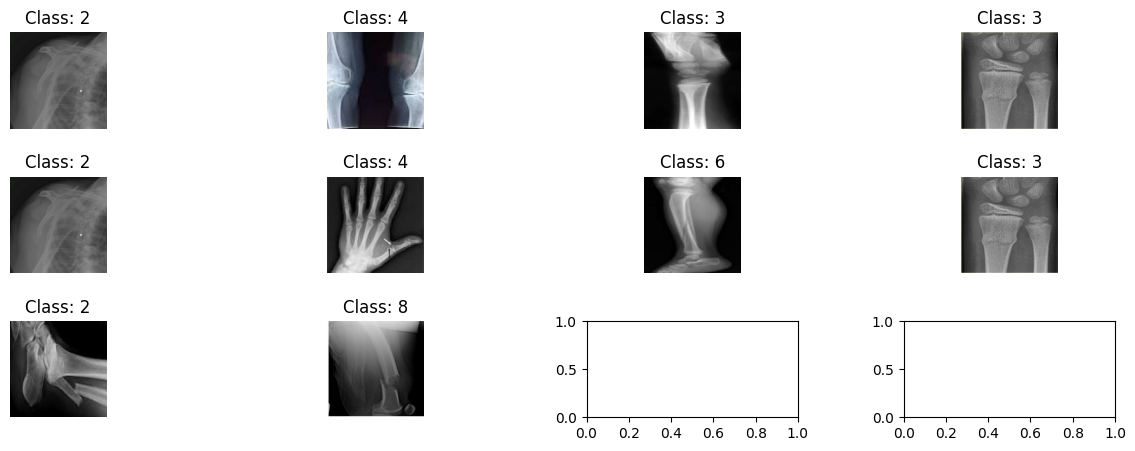

In [10]:
# display sample train images

sample_images = x_train[:100]

display(sample_images)

In [11]:
# view tensor shape

x_train.shape

(1017, 256, 256, 3)

In [12]:
# one-hot encode the train, val data

NUM_CLASSES = len(class_names)

y_train = utils.to_categorical(y_train, NUM_CLASSES)
y_val = utils.to_categorical(y_val, NUM_CLASSES)

## MLP

In [13]:
input_layer = layers.Input(shape=(256, 256, 3), name="input_layer")

# Flatten to Vector before inputing in Dense Layer

x = layers.Flatten()(input_layer)

x = layers.Dense(units=300)(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Dense(units=250)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Dense(units=200)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Dense(units=150)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Dense(units=100)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)

output_layer = layers.Dense(units=10, activation="softmax")(x)

model = models.Model(input_layer, output_layer)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 flatten (Flatten)           (None, 196608)            0         
                                                                 
 dense (Dense)               (None, 300)               58982700  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 300)               0         
                                                                 
 dense_1 (Dense)             (None, 250)               75250     
                                                                 
 batch_normalization (Batch  (None, 250)               1000      
 Normalization)                                                  
                                                             

In [14]:
# compile
opt = optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

In [15]:
model.fit(
    x_train,
    y_train,
    batch_size=32,
    epochs=16,
    shuffle=True
)

Epoch 1/16
32/32 [==============================] - 24s 658ms/step - loss: 2.4601 - accuracy: 0.1396
Epoch 2/16
32/32 [==============================] - 21s 650ms/step - loss: 2.1522 - accuracy: 0.2498
Epoch 3/16
32/32 [==============================] - 21s 660ms/step - loss: 2.0260 - accuracy: 0.2901
Epoch 4/16
32/32 [==============================] - 21s 657ms/step - loss: 1.9288 - accuracy: 0.3422
Epoch 5/16
32/32 [==============================] - 21s 646ms/step - loss: 1.8570 - accuracy: 0.3559
Epoch 6/16
32/32 [==============================] - 21s 659ms/step - loss: 1.7826 - accuracy: 0.3677
Epoch 7/16
32/32 [==============================] - 21s 659ms/step - loss: 1.6930 - accuracy: 0.4238
Epoch 8/16
32/32 [==============================] - 21s 649ms/step - loss: 1.6090 - accuracy: 0.4553
Epoch 9/16
32/32 [==============================] - 21s 659ms/step - loss: 1.5465 - accuracy: 0.4897
Epoch 10/16
32/32 [==============================] - 21s 648ms/step - loss: 1.4307 - accura

In [16]:
# Evaluate Model

model.evaluate(x_val, y_val)

4/4 [==============================] - 1s 52ms/step - loss: 0.8819 - accuracy: 0.7321


[0.8819481134414673, 0.7321428656578064]

In [17]:
CLASSES = np.array(class_names)

preds = model.predict(x_val)

4/4 [==============================] - 0s 57ms/step


In [18]:
preds_single = CLASSES[np.argmax(preds, axis=-1)]
actual_single = CLASSES[np.argmax(y_val, axis=-1)]

In [19]:
def display_preds_act(n=10, figsize=(15,3)):
    
    indices = np.random.choice(range(len(y_val)), n)
    
    fig = plt.figure(figsize=figsize)
    fig.subplots_adjust(wspace=0.5, hspace=0.5)
    
    for i, idx in enumerate(indices):
        img = x_val[idx]
        ax = fig.add_subplot(1, n, i + 1)
        ax.axis("off")
        ax.text(0.5, -0.35, "pred = " + str(preds_single[idx].split(" ")[0][:4]), fontsize=10, ha="center", transform=ax.transAxes)
        ax.text(0.5, -0.7, "act = " + str(actual_single[idx].split(" ")[0][:4]), fontsize=10, ha="center", transform=ax.transAxes)
        ax.imshow(img)

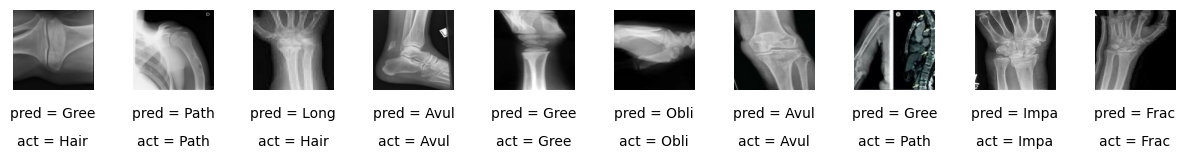

In [20]:
# predicstions with MLP
display_preds_act(n=10)

## CNN

In [21]:
input_layer = layers.Input(shape=(256,256, 3))

x = layers.Conv2D(
    filters=32,
    kernel_size=(3,3),
    strides=2,
    padding="same"
)(input_layer)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(rate=0.2)(x)

x = layers.Conv2D(
    64,
    3,
    strides=2,
    padding="same"
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(rate=0.2)(x)

x = layers.Conv2D(
    128,
    3,
    strides=2,
    padding="same"
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(rate=0.2)(x)

x = layers.Conv2D(
    256,
    3,
    strides=2,
    padding="same"
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(rate=0.2)(x)

x = layers.Flatten()(x)

x = layers.Dense(units=100)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(rate=0.2)(x)

output_layer = layers.Dense(units=10, activation="softmax")(x)

model2 = models.Model(input_layer, output_layer)

model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_4 (Bat  (None, 128, 128, 32)      128       
 chNormalization)                                                
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 128, 128, 32)      0         
                                                                 
 dropout (Dropout)           (None, 128, 128, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                           

In [22]:
opt = optimizers.Adam(learning_rate=0.0005)
model2.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [23]:
# save checkpoints to monitor best performing models

model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint",
    save_weights_only = False,
    save_freq = "epoch",
    monitor = "loss",
    mode = "min",
    save_best_only = True,
    verbose = 0
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

In [24]:
history = model2.fit(
    x_train,
    y_train,
    shuffle=True,
    batch_size=32,
    epochs=10,
    validation_data=(x_val, y_val),
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
    ]
)

Epoch 1/10
32/32 [==============================] - 42s 1s/step - loss: 2.6400 - accuracy: 0.1622 - val_loss: 2.0984 - val_accuracy: 0.2500
Epoch 2/10
32/32 [==============================] - 39s 1s/step - loss: 1.9679 - accuracy: 0.3353 - val_loss: 1.8407 - val_accuracy: 0.3125
Epoch 3/10
32/32 [==============================] - 38s 1s/step - loss: 1.5788 - accuracy: 0.4749 - val_loss: 1.2638 - val_accuracy: 0.5536
Epoch 4/10
32/32 [==============================] - 39s 1s/step - loss: 1.1572 - accuracy: 0.6273 - val_loss: 0.8859 - val_accuracy: 0.7232
Epoch 5/10
32/32 [==============================] - 40s 1s/step - loss: 0.7555 - accuracy: 0.7886 - val_loss: 0.4977 - val_accuracy: 0.9107
Epoch 6/10
32/32 [==============================] - 40s 1s/step - loss: 0.4591 - accuracy: 0.9066 - val_loss: 0.3627 - val_accuracy: 0.9196
Epoch 7/10
32/32 [==============================] - 39s 1s/step - loss: 0.3016 - accuracy: 0.9518 - val_loss: 0.2970 - val_accuracy: 0.9464
Epoch 8/10
32/32 [==

In [25]:
train_loss = history.history["loss"]
train_accuracy = history.history["accuracy"]
val_loss = history.history["val_loss"]
val_accuracy = history.history["accuracy"]

In [26]:
model2.evaluate(x_val, y_val)

4/4 [==============================] - 1s 208ms/step - loss: 0.2465 - accuracy: 0.9464


[0.24649497866630554, 0.9464285969734192]

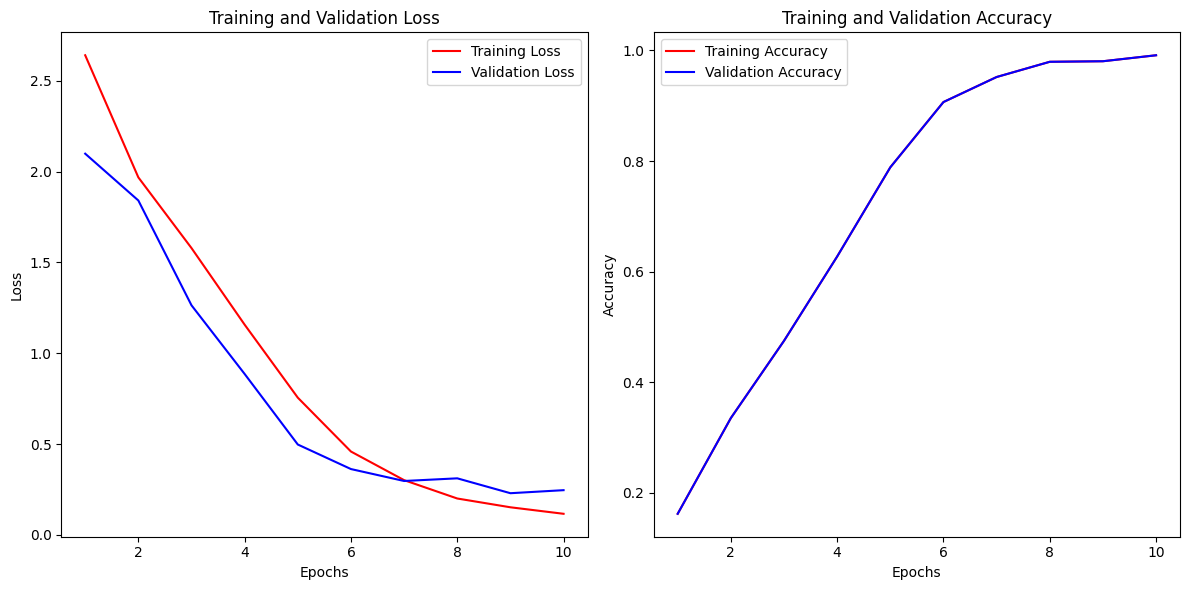

In [27]:
# plot learning curve

epochs= range(1,11)

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(epochs, train_loss, 'r-', label="Training Loss")
plt.plot(epochs, val_loss, 'b-', label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_accuracy, 'r-', label="Training Accuracy")
plt.plot(epochs, val_accuracy, 'b-', label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [28]:
#predictions

preds = model2.predict(x_val)

4/4 [==============================] - 1s 284ms/step


In [29]:
preds_single = CLASSES[np.argmax(preds, axis=-1)]
actual_single = CLASSES[np.argmax(y_val, axis=-1)]

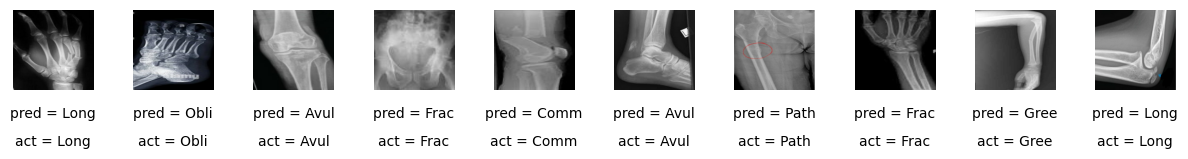

In [30]:
#Predictions

display_preds_act()